<a href="https://colab.research.google.com/github/moch1996/MachineLearningProj/blob/master/assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#모듈
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.optim import lr_scheduler

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
print(device)

cuda:0


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [5]:
#MNIST DATA
data_train = datasets.MNIST(root = 'MNIST_data',
                             download=True,
                             train=False,
                             transform=transform
                             )
data_test = datasets.MNIST(root = 'MNIST_data', 
                             train= True, 
                             download=True, 
                             transform= transform)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
print("the number of your training data (must be 10,000) = ", data_train.__len__())
print("hte number of your testing data (must be 60,000) = ", data_test.__len__())

the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


In [8]:
batch_size = 125
train_loader = torch.utils.data.DataLoader(dataset = data_train,
                                          batch_size=batch_size,
                                          shuffle = True,
                                          drop_last = True)
test_loader = torch.utils.data.DataLoader(dataset = data_test,
                                          batch_size=batch_size,
                                          shuffle = True,
                                          drop_last = True)
print('number of train batch : ',len(train_loader))
print('number of train batch : ',len(test_loader))

number of train batch :  80
number of train batch :  480


In [12]:
class classification(nn.Module):
    def __init__(self):
        super(classification,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           
            nn.Conv2d(32, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),            
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )       
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [10]:
learning_rate = 0.001
num_epoch = 40

In [11]:
classifier = classification().to(device)
optimizer = torch.optim.Adam(classifier.parameters(),lr=learning_rate)
loss_func = nn.NLLLoss().to(device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1, patience=1, mode='min')

In [13]:
for i in range(1,10) :
  if i > 5 :
    print(i) 

6
7
8
9


In [381]:
training_L_history = []
training_A_history = []
testing_L_history = []
testing_A_history = []
for epoch in range(1,num_epoch+1) :
    classifier.train()
    training_loss = 0
    training_correct = 0
    for i,(data,target) in enumerate(train_loader) :
        
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        result = classifier(data)

        loss = F.nll_loss(result,target)
        training_loss += F.nll_loss(result,target, reduction = 'sum').item()

        prediction = result.max(dim=1, keepdim=True)[1]
        training_correct += prediction.eq(target.view_as(prediction)).sum().item()

        loss.backward()
        optimizer.step()
    scheduler.step(loss)
    training_loss /= len(train_loader.dataset)
    training_accuracy = 100 * training_correct / len(train_loader.dataset)
    training_L_history.append(training_loss)
    training_A_history.append(training_accuracy)
    

    classifier.eval()
    testing_loss = 0
    testing_correct = 0
    with torch.no_grad() :
      for data, target in test_loader :
        data,target = data.to(device), target.to(device)

        result2 = classifier(data)

        loss2 = F.nll_loss(result2, target)
        testing_loss += F.nll_loss(result2, target, reduction = 'sum').item()

        prediction2 = result2.max(1, keepdim=True)[1]
        testing_correct += prediction2.eq(target.view_as(prediction2)).sum().item()
    testing_loss /= len(test_loader.dataset)
    testing_accuracy = 100 * testing_correct / len(test_loader.dataset)
    testing_L_history.append(testing_loss)
    testing_A_history.append(testing_accuracy)
    if epoch > num_epoch-10 :
      print('Epoch: {}, Loss: {}, LR: {}'.format(epoch, loss.item(), scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

KeyboardInterrupt: ignored

In [319]:
testing_A_history

[97.11666666666666,
 97.785,
 98.24666666666667,
 98.24833333333333,
 98.50166666666667,
 98.44,
 98.58,
 98.56333333333333,
 98.56166666666667,
 98.55333333333333,
 98.555,
 98.61333333333333,
 98.61333333333333,
 98.605,
 98.59166666666667,
 98.6,
 98.62,
 98.615,
 98.635,
 98.67166666666667,
 98.64166666666667,
 98.63666666666667,
 98.65166666666667,
 98.63833333333334,
 98.66833333333334,
 98.665,
 98.62666666666667,
 98.64833333333333,
 98.65333333333334,
 98.64166666666667,
 98.65333333333334,
 98.645,
 98.63166666666666,
 98.645,
 98.63833333333334,
 98.65666666666667,
 98.65666666666667,
 98.63833333333334,
 98.64,
 98.625]

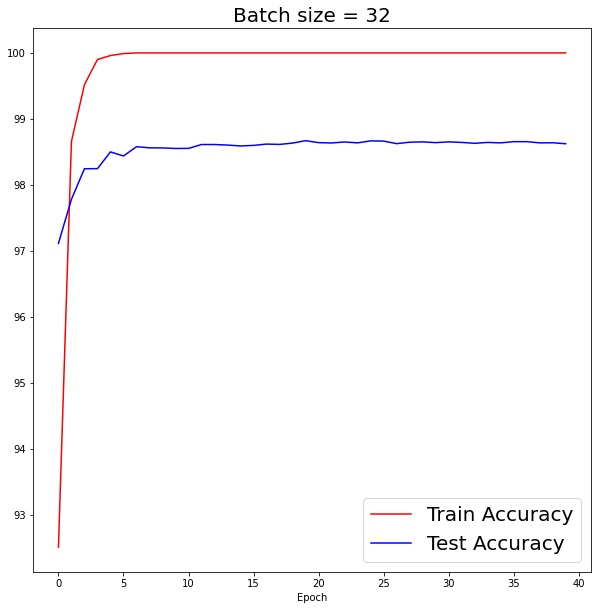

In [320]:
plt.figure(3, figsize=(10,10))
plt.plot(np.array(range(40)), training_A_history, c='r',label='Train Accuracy')
plt.plot(np.array(range(40)), testing_A_history, c='blue',label='Test Accuracy')
plt.xlabel('Epoch')
plt.title('Batch size = 32',fontsize = 20)
plt.legend(fontsize =20, loc='best')
plt.show()

In [321]:
print(np.argmax(testing_A_history),"        ",np.max(testing_A_history))

19          98.67166666666667


In [367]:
#찐
class classification(nn.Module):
    def __init__(self):
        super(classification,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           
            nn.Conv2d(32, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),            
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )       
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

#OUTPUT